In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange
from importlib import reload

import utils.policies as polc
import utils.experiment as expt
import utils.misc as mutil

reload(polc)
reload(expt)
reload(mutil);

In [2]:
def perform_regret_experiment(arrival_rate, noise_variance):
    # simulation lengths
    T_horizon = None # time horizon (to be set later)
    T_horizon_list = 2000*np.arange(1,11)
    N_runs = 50 # number of simulations

    # noise and arrival rates
    def random_uniform(size = []):
        return 2*np.random.uniform(size = size)-1
    noise_distribution = random_uniform # np.random.standard_normal

    # algorithm parameters
    beta  = 4.5*noise_variance # exploration tuner (should theoretically be > 4 sigma^2)
    nu    = None # backlog-cost tradeoff tuner (should theoretically be T^{1/3}) (to be set later)
    delta = None # exploration tuner (should theoretically be T^{(-2 sigma^2)/(beta - 2 sigma^2)}) (to be set later)

    # topology
    N_nodes          = 9
    source_node      = 0
    destination_node = 8
    edges_list       = [[0,1], [0,4], [0,2], [1,3], [1,4], [2,5], [3,6], [6,4], [4,6], [4,7], [5,4], [5,7], [6,8], [4,8], [7,8]]
    node_edge_adjacency = mutil.prepare_adjacency(edges_list, N_nodes)

    # edge properties
    edge_capacities = np.array([4,2,2,2,2,2,2,1,1,1,1,1,2,5,2]) # max-flow = 8
    true_edge_costs = np.array([2,5,1,1,2,1,1,1,1,1,1,3,3,1,1])/10

    # pack parameters
    simulation_params = mutil.SimulationParameters(node_edge_adjacency, 
                    true_edge_costs, edge_capacities, 
                    source_node, destination_node, 
                    noise_variance, noise_distribution,
                    arrival_rate, 
                    N_runs, T_horizon, 
                    beta, delta, nu)

    # visualize topology
    # mutil.visualize_network(edges_list, N_nodes)

    # get solution to static optimization problem
    stat_edge_rates = polc.get_static_policy(node_edge_adjacency, source_node, destination_node, true_edge_costs, edge_capacities, arrival_rate)
    total_stat_cost_per_time = stat_edge_rates@true_edge_costs
    stat_costs = T_horizon_list*total_stat_cost_per_time

    # intialization
    tran_cost_till_T_dpop = np.zeros(T_horizon_list.shape)
    backlog_cost_at_T_dpop = np.zeros(T_horizon_list.shape)

    # iterate over given T values
    for jj in trange(T_horizon_list.shape[0]):
        ii = T_horizon_list.shape[0] - jj - 1

        # change policy parameters for this value of T
        simulation_params = expt.set_simulation_params(simulation_params, T_horizon_list[ii])

        # run experiment for this value of T
        queueing_network = expt.run_experiment(simulation_params, policy = 'dpop', custom_seed = 13)
        
        # save cost and backlog values
        tran_cost_till_tt, backlog_cost_at_tt = expt.calculate_total_costs(queueing_network)
        tran_cost_till_T_dpop[ii] = tran_cost_till_tt[-1]
        backlog_cost_at_T_dpop[ii] = backlog_cost_at_tt[-1]

    # calculate total cost
    dpop_costs = tran_cost_till_T_dpop + backlog_cost_at_T_dpop

    # save results
    save_result = np.vstack((T_horizon_list, dpop_costs, stat_costs))
    save_file = 'regret-lambda-' + str(arrival_rate).replace('.','_') + '-var-' + str(noise_variance).replace('.','_')
    np.save('./results/' + save_file, save_result)

    # get theoretical fit
    dpop_regret = dpop_costs - stat_costs
    theoretical_dpop_regret, curve_coefficients = mutil.fit_regret_curve(T_horizon_list, dpop_regret)

    # print summary
    print('Arrival rate = ' + str(arrival_rate) + ', noise variance = ' + str(noise_variance))
    print('Coefficients [1 T^{1/3} sqrt(T)log(T)] = ' + np.array2string(curve_coefficients, precision=3, suppress_small=True))
    print('True costs = ' + str(true_edge_costs))
    print('Mean observed costs = ' + np.array2string(queueing_network.edge_cost_means[0,:], precision=3, suppress_small=True))

    # plot regret
    plt.plot(T_horizon_list, dpop_costs - stat_costs, label = 'dpop regret')
    plt.plot(T_horizon_list, theoretical_dpop_regret, '-.', label = 'theoretical regret')
    plt.legend()
    plt.show()

100%|██████████| 10/10 [10:51<00:00, 65.13s/it]

Arrival rate = 2, noise variance = 0
Coefficients [1 T^{1/3} sqrt(T)log(T)] = [ 0.    64.398  0.771]
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]


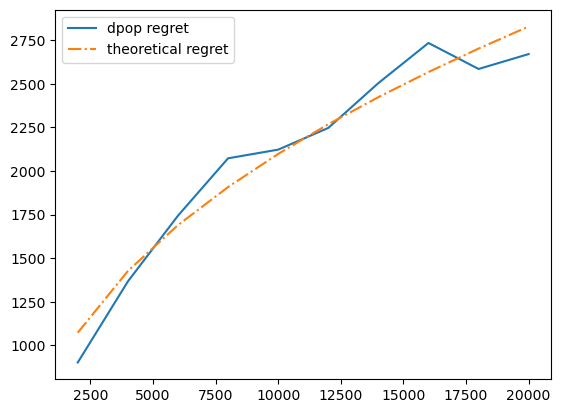

100%|██████████| 10/10 [10:15<00:00, 61.56s/it]

Arrival rate = 2, noise variance = 0.01
Coefficients [1 T^{1/3} sqrt(T)log(T)] = [ 0.    59.69   2.003]
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [0.205 0.501 0.1   0.099 0.197 0.1   0.099 0.098 0.102 0.1   0.1   0.3
 0.305 0.1   0.1  ]


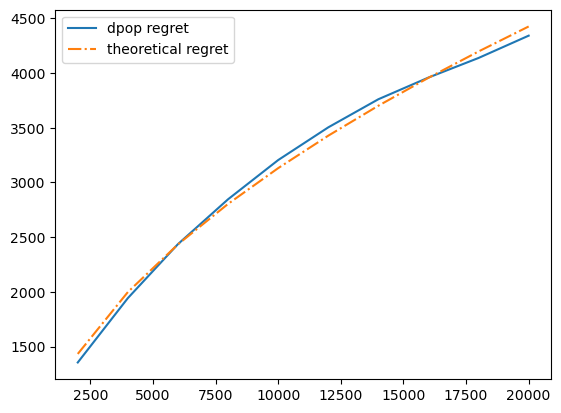

100%|██████████| 10/10 [10:11<00:00, 61.14s/it]

Arrival rate = 2, noise variance = 0.05
Coefficients [1 T^{1/3} sqrt(T)log(T)] = [ 0.    87.856  2.785]
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [0.206 0.518 0.103 0.097 0.196 0.101 0.092 0.097 0.1   0.093 0.098 0.296
 0.304 0.101 0.099]


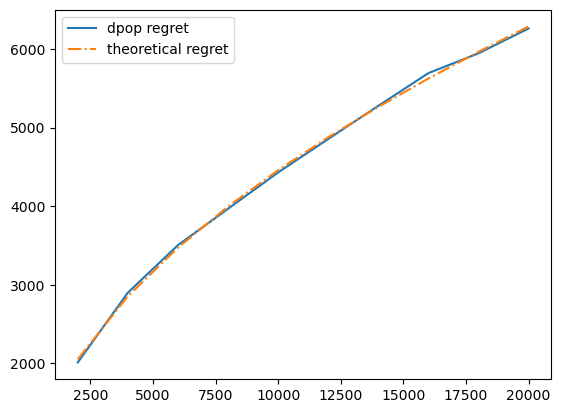

100%|██████████| 10/10 [10:11<00:00, 61.16s/it]

Arrival rate = 2, noise variance = 0.1
Coefficients [1 T^{1/3} sqrt(T)log(T)] = [100.    100.      3.572]
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [0.205 0.499 0.1   0.099 0.191 0.108 0.091 0.094 0.106 0.093 0.095 0.291
 0.297 0.094 0.1  ]


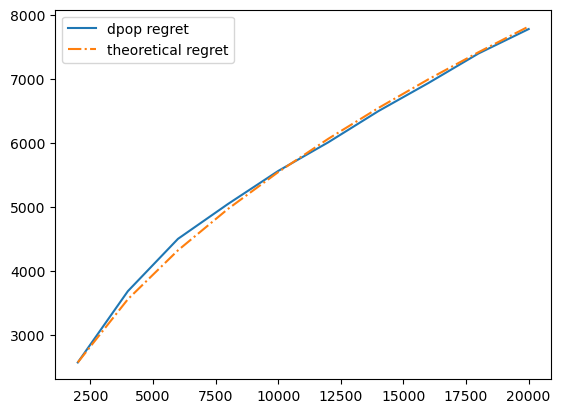

100%|██████████| 10/10 [10:10<00:00, 61.03s/it]

Arrival rate = 4, noise variance = 0
Coefficients [1 T^{1/3} sqrt(T)log(T)] = [ 0.    29.529  2.782]
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]


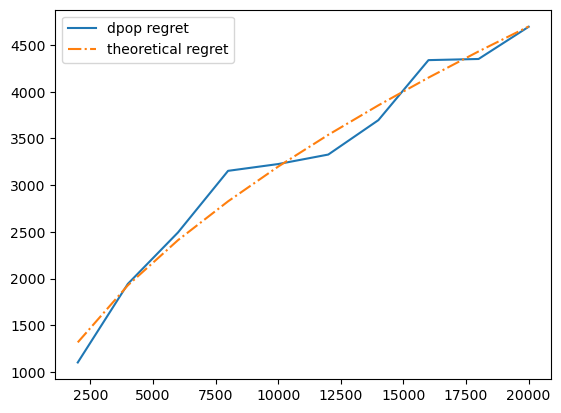

100%|██████████| 10/10 [10:09<00:00, 60.94s/it]

Arrival rate = 4, noise variance = 0.01
Coefficients [1 T^{1/3} sqrt(T)log(T)] = [ 0.    11.972  3.858]
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [0.201 0.501 0.099 0.101 0.199 0.102 0.097 0.099 0.102 0.098 0.099 0.299
 0.302 0.099 0.098]


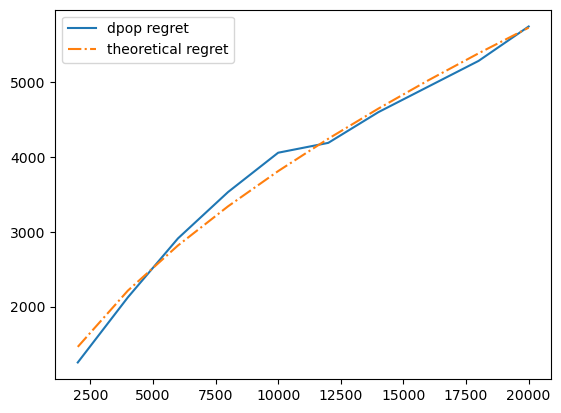

100%|██████████| 10/10 [10:10<00:00, 61.10s/it]

Arrival rate = 4, noise variance = 0.05
Coefficients [1 T^{1/3} sqrt(T)log(T)] = [ 0.    15.283  4.61 ]
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [0.204 0.501 0.099 0.104 0.191 0.102 0.094 0.094 0.105 0.098 0.096 0.3
 0.294 0.098 0.098]


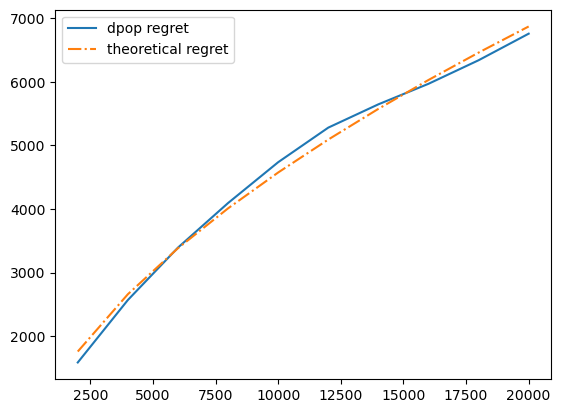

100%|██████████| 10/10 [10:11<00:00, 61.17s/it]

Arrival rate = 4, noise variance = 0.1
Coefficients [1 T^{1/3} sqrt(T)log(T)] = [ 0.    22.641  5.182]
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [0.204 0.497 0.099 0.104 0.19  0.1   0.09  0.094 0.103 0.097 0.095 0.296
 0.3   0.097 0.097]


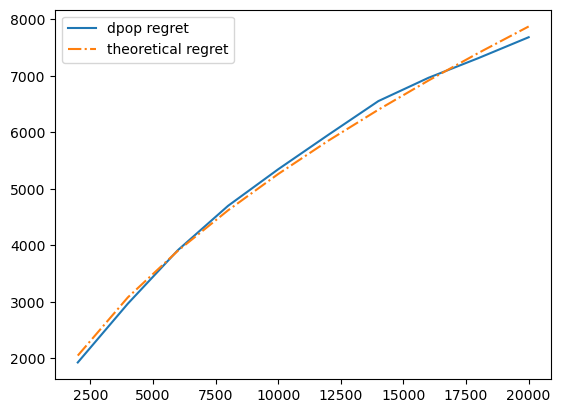

100%|██████████| 10/10 [10:11<00:00, 61.12s/it]

Arrival rate = 6, noise variance = 0
Coefficients [1 T^{1/3} sqrt(T)log(T)] = [ 34.073 100.      0.5  ]
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]


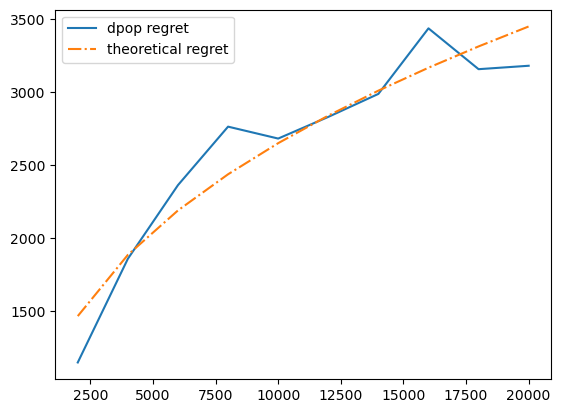

100%|██████████| 10/10 [10:11<00:00, 61.15s/it]

Arrival rate = 6, noise variance = 0.01
Coefficients [1 T^{1/3} sqrt(T)log(T)] = [ 0.    88.669  1.511]
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [0.201 0.501 0.099 0.101 0.198 0.101 0.098 0.098 0.101 0.098 0.097 0.299
 0.301 0.098 0.099]


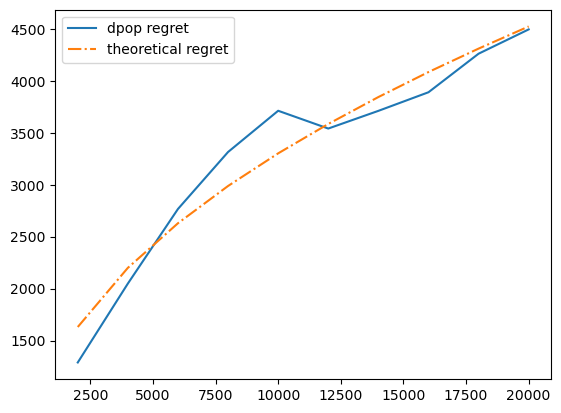

100%|██████████| 10/10 [10:09<00:00, 60.97s/it]

Arrival rate = 6, noise variance = 0.05
Coefficients [1 T^{1/3} sqrt(T)log(T)] = [ 0.    74.861  2.616]
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [0.203 0.505 0.099 0.103 0.195 0.101 0.093 0.097 0.107 0.095 0.097 0.297
 0.3   0.097 0.098]


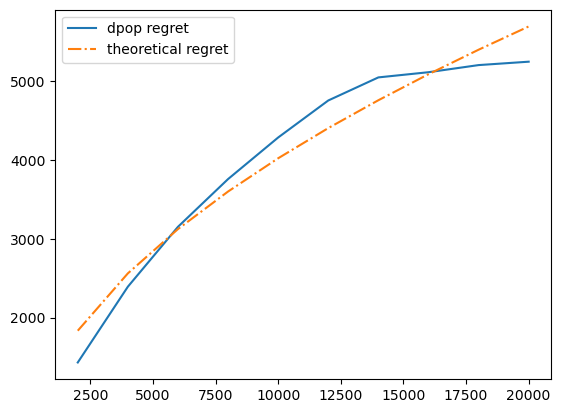

100%|██████████| 10/10 [10:10<00:00, 61.01s/it]

Arrival rate = 6, noise variance = 0.1
Coefficients [1 T^{1/3} sqrt(T)log(T)] = [ 0.    41.505  3.983]
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [0.203 0.502 0.097 0.102 0.194 0.103 0.087 0.092 0.103 0.095 0.092 0.298
 0.304 0.096 0.097]


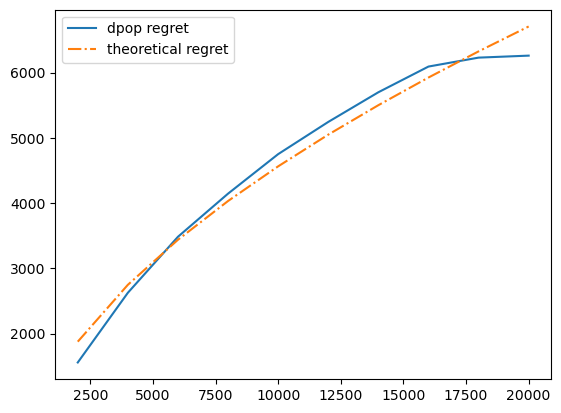

In [3]:
for arrival_rate in [2,4,6]:
    for noise_variance in [0,0.01,0.05,0.1]:
        perform_regret_experiment(arrival_rate, noise_variance)